### this is the notebook where im making the model, testing out input shapes, plotting stuff. 
## the training python file does the training, but ill have the code here too


In [1]:
# %pip install numpy pandas matplotlib
# %pip install scipy plotly torch torchvision torchaudio torchsummary requests tqdm wandb h5py zarr psutil tensorflow keras opencv-python

In [ ]:
import torch
import torchvision
import os
import numpy as np

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Download MNIST dataset and convert into 32x32 images
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 60000
Test samples: 10000


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

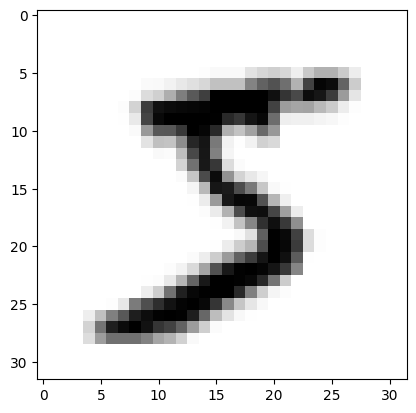

In [3]:
plt.imshow(train_dataset[0][0][0],cmap="binary")
plt.show()

## MODEL

### helper stuff for the model

In [4]:
def space_to_depth(x, size=2):
    """
    Downscale method that uses the depth dimension to
    downscale the spatial dimensions
    """
    b, c, h, w = x.shape
    # print(b,c,h,w)
    assert h % size == 0 and w % size == 0, "height/width must be divisible by size"
    out_h = h // size
    out_w = w // size
    out_c = c * (size * size)

    x = x.reshape((b, c, out_h, size, out_w, size))
    x = x.permute((0, 1, 3, 5, 2, 4))
    x = x.reshape((b, out_c, out_h, out_w))
    return x


class SpaceToDepth(nn.Module):
    def __init__(self, size, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.size = size

    def forward(self, x):
        return space_to_depth(x, self.size)


class Residual(nn.Module):
    """
    Apply residual connection using an input function
    """
    def __init__(self, func, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.func = func

    def forward(self, x, *args, **kwargs):
        return x + self.func(x, *args, **kwargs)


def upsample(in_channels, out_channels=None):
    out_channels = in_channels if out_channels is None else out_channels
    seq = nn.Sequential(
        nn.Upsample(scale_factor=2, mode="nearest"),
        nn.Conv2d(in_channels, out_channels, 3, padding=1)
    )
    return seq


def downsample(in_channels, out_channels=None):
    out_channels = in_channels if out_channels is None else out_channels
    seq = nn.Sequential(
        SpaceToDepth(2),
        nn.Conv2d(4 * in_channels, out_channels, 1)
    )
    return seq


class SinusodialPositionEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim

    def forward(self, time_steps):
        positions = torch.unsqueeze(time_steps, 1)
        embeddings = torch.zeros((time_steps.shape[0], self.embedding_dim), device=time_steps.device)
        denominators = 10_000 ** (2 * torch.arange(self.embedding_dim // 2, device=time_steps.device) / self.embedding_dim)
        embeddings[:, 0::2] = torch.sin(positions / denominators)
        embeddings[:, 1::2] = torch.cos(positions / denominators)
        return embeddings


class WeightStandardizedConv2d(nn.Conv2d):
    """
    Weight Standardized Conv2d compatible with nn.Conv2d args.
    https://arxiv.org/abs/1903.10520
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size,
                         stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        weight = self.weight
        mean = weight.mean(dim=[1, 2, 3], keepdim=True)
        variance = weight.var(dim=[1, 2, 3], keepdim=True, correction=0)
        normalized_weight = (weight - mean) / torch.sqrt(variance + eps)
        return F.conv2d(
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups
        )


class Block(nn.Module):
    def __init__(self, in_channels, out_channels, groups=8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(in_channels, out_channels, 3, padding=1)
        self.norm = nn.GroupNorm(groups, out_channels)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)
        if scale_shift is not None:
            scale, shift = scale_shift
            x = x * (scale + 1) + shift
        x = self.act(x)
        return x


class ResnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_embed_dim=None, groups=8):
        super().__init__()
        if time_embed_dim is not None:
            self.mlp = nn.Sequential(
                nn.SiLU(),
                nn.Linear(time_embed_dim, 2 * out_channels)
            )
        else:
            self.mlp = None

        self.block1 = Block(in_channels, out_channels, groups)
        self.block2 = Block(out_channels, out_channels, groups)

        if in_channels == out_channels:
            self.res_conv = nn.Identity()
        else:
            self.res_conv = nn.Conv2d(in_channels, out_channels, 1)

    def forward(self, x, time_embedding=None):
        scale_shift = None
        if self.mlp is not None and time_embedding is not None:
            time_emb = self.mlp(time_embedding)
            time_emb = time_emb.view(*time_emb.shape, 1, 1)
            scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)


class Attention(nn.Module):
    def __init__(self, in_channels, num_heads=4, dim_head=32):
        super().__init__()
        self.num_heads = num_heads
        self.dim_head = dim_head
        self.scale_factor = 1 / (dim_head) ** 0.5
        self.hidden_dim = num_heads * dim_head
        self.input_to_qkv = nn.Conv2d(in_channels, 3 * self.hidden_dim, 1, bias=False)
        self.to_output = nn.Conv2d(self.hidden_dim, in_channels, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.input_to_qkv(x)
        q, k, v = map(lambda t: t.view(b, self.num_heads, self.dim_head, h * w), qkv.chunk(3, dim=1))
        q = q * self.scale_factor
        sim = torch.einsum("b h c i, b h c j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attention = sim.softmax(dim=-1)
        output = torch.einsum("b h i j, b h c j -> b h i c", attention, v)
        output = output.permute(0, 1, 3, 2).reshape((b, self.hidden_dim, h, w))
        return self.to_output(output)


class LinearAttention(nn.Module):
    def __init__(self, in_channels, num_heads=4, dim_head=32):
        super().__init__()
        self.num_heads = num_heads
        self.dim_head = dim_head
        self.scale_factor = 1 / (dim_head) ** 0.5
        self.hidden_dim = num_heads * dim_head
        self.input_to_qkv = nn.Conv2d(in_channels, 3 * self.hidden_dim, 1, bias=False)
        self.to_output = nn.Sequential(
            nn.Conv2d(self.hidden_dim, in_channels, 1),
            nn.GroupNorm(1, in_channels)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.input_to_qkv(x)
        q, k, v = map(lambda t: t.view(b, self.num_heads, self.dim_head, h * w), qkv.chunk(3, dim=1))

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale_factor
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)
        output = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        output = output.view((b, self.hidden_dim, h, w))
        return self.to_output(output)


class PreGroupNorm(nn.Module):
    def __init__(self, dim, func, groups=1):
        super().__init__()
        self.func = func
        self.group_norm = nn.GroupNorm(groups, dim)

    def forward(self, x):
        x = self.group_norm(x)
        x = self.func(x)
        return x


## THE U NET MODEL WITH CONDITION

In [32]:

class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, use_attn=False):
        super().__init__()
        self.block1 = ResnetBlock(in_ch, out_ch, time_embed_dim=time_emb_dim)
        self.block2 = ResnetBlock(out_ch, out_ch, time_embed_dim=time_emb_dim)
        self.attn = Attention(out_ch) if use_attn else nn.Identity()
        self.down = downsample(out_ch)

    def forward(self, x, cond):
        # print(f"DownBlock input: {x.shape}, cond: {getattr(cond,'shape',None)}")
        x = self.block1(x, cond)
        # print(f" after block1: {x.shape}")
        x = self.block2(x, cond)
        # print(f" after block2: {x.shape}")
        x = self.attn(x)
        # print(f" after attn: {x.shape}")
        x = self.down(x)
        # print(f" after downsample: {x.shape}")
        return x
    
class UpBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch, time_emb_dim, use_attn=False):
        super().__init__()
        # input will be (in_ch + skip_ch)
        self.upconv = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1)
        self.block1 = ResnetBlock(out_ch + skip_ch, out_ch, time_embed_dim=time_emb_dim)
        self.block2 = ResnetBlock(out_ch, out_ch, time_embed_dim=time_emb_dim)
        self.attn = Attention(out_ch) if use_attn else nn.Identity()

    def forward(self, x, skip, cond):
        # upsample first
        x = self.upconv(x)  # (B, out_ch, H*2, W*2)

        # concat skip connection
        x = torch.cat([x, skip], dim=1)

        # process with resnet+attn
        x = self.block1(x, cond)
        x = self.block2(x, cond)
        x = self.attn(x)
        return x


class GabiDiffUnet(nn.Module):

    def __init__(self,time_emb_dim=128, num_classes = 10, in_channels = 3,resnet_depth=4, image_size=28):
        super().__init__()
        self.image_size = image_size
        #time and label embedding
        self.time_mlp = nn.Sequential(
            SinusodialPositionEmbedding(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.GELU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim)
        )
        
        self.label_emb = nn.Embedding(num_classes, time_emb_dim)

        #DOWNSAMPLE 
        self.downsample = nn.ModuleList()
        for i in range(resnet_depth):
            in_ch = in_channels if i == 0 else out_ch
            out_ch = 64 * (2 ** i)
            self.downsample.append(
                DownBlock(in_ch, out_ch, time_emb_dim=time_emb_dim, use_attn=(i % 2 == 0))
            )

        #BOTTLENECK
        self.bottleneck = nn.Sequential(
            ResnetBlock(64 * (2 ** (resnet_depth - 1)), 64 * (2 ** (resnet_depth - 1)), time_embed_dim=time_emb_dim),
            ResnetBlock(64 * (2 ** (resnet_depth - 1)), 64 * (2 ** (resnet_depth - 1)), time_embed_dim=time_emb_dim),
            Attention(64 * (2 ** (resnet_depth - 1)))
        )

        self.upsample = nn.ModuleList()
        ch_list = [64 * (2 ** i) for i in range(resnet_depth)]  # [64, 128, 256, 512]

        for i in range(resnet_depth - 1, -1, -1):
            in_ch = ch_list[i] if i == resnet_depth - 1 else out_ch  # coming from below
            skip_ch = ch_list[i]  # skip connection channels
            out_ch = skip_ch if i > 0 else 64  # final goes back to 64
            self.upsample.append(
                UpBlock(in_ch, skip_ch, out_ch, time_emb_dim=time_emb_dim, use_attn=(i % 2 == 0))
            )


        #FINAL BLOCK
        self.final_block = nn.Sequential(
            ResnetBlock(64, 64, time_embed_dim=time_emb_dim),
            ResnetBlock(64, 64, time_embed_dim=time_emb_dim),
            nn.Conv2d(64, 3, kernel_size=1)
        )

    def forward(self, x, time_stamp, labels=None):

        # print(f"Model input x: {x.shape}, time_stamp: {getattr(time_stamp,'shape',None)}, labels: {getattr(labels,'shape',None)}")

        #Time and Label Embeddings
        time_emb = self.time_mlp(time_stamp)
        # print(f" time_emb: {time_emb.shape}")
        label_emb = self.label_emb(labels) if labels is not None else torch.zeros_like(time_emb)
        # print(f" label_emb: {getattr(label_emb,'shape',None)}")

        cond = time_emb + label_emb
        # print(f" cond: {cond.shape}")

        skips = []
        #down path
        for i, layer in enumerate(self.downsample):
            x = layer(x, cond)
            skips.append(x)
            # print(f" after downsample layer {i}: {x.shape}")


        #bottleneck
        x = self.bottleneck[0](x, cond)
        # print(f" after bottleneck block0: {x.shape}")
        x = self.bottleneck[1](x, cond)
        # print(f" after bottleneck block1: {x.shape}")
        x = self.bottleneck[2](x)
        # print(f" after bottleneck attn: {x.shape}")

        #up path
        for i, layer in enumerate(self.upsample):
            skip = skips[-(i+1)]
            x = layer(x, skip, cond)
            # print(f" after upsample layer {i}: {x.shape}")

        h0 = self.final_block[0](x, cond)
        # print(f" final_block[0] out: {h0.shape}")
        h1 = self.final_block[1](h0, cond)
        # print(f" final_block[1] out: {h1.shape}")
        k = self.final_block[2](h1)
        # print(f" final output k: {k.shape}")

        return k 

In [33]:
model = GabiDiffUnet(resnet_depth=4, image_size=32)
# print(model)

#pass in sample input and output, and print input and output shapes
input_tensor = torch.randn(1, 3, 32, 32)
time_stamp = torch.tensor([0.5])  # Example time step
output = model(input_tensor, time_stamp)

print("Input shape:", input_tensor.shape)
print("Output:", output.shape)


print(model)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 4 but got size 2 for tensor number 1 in the list.

## forward process and noisy images sampling

### forward process
![forward process](https://miro.medium.com/v2/resize:fit:640/format:webp/0*WK3wnFRWC2GIcH1r.png)

In [ ]:
#DDPM
# the constant Beta tells us how much noise is added at each timestamp
def linear_schedule(num_timesteps):
  beta_start = 1e-4
  beta_end = 0.02
  betas = torch.linspace(beta_start, beta_end, num_timesteps)
  return betas

#improved DDPM paper used cosine schedule it seems
def cosine_schedule(num_timesteps, s=0.008):
  def f(t):
    return torch.cos((t / num_timesteps + s) / (1 + s) * 0.5 * torch.pi) ** 2
  x = torch.linspace(0, num_timesteps, num_timesteps + 1)
  alphas_cumprod = f(x) / f(torch.tensor([0]))
  betas = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
  betas = torch.clip(betas, 0.0001, 0.999)
  return betas

def sample_by_t(tensor_to_sample, timesteps, x_shape):
  batch_size = timesteps.shape[0]
  sampled_tensor = tensor_to_sample.gather(-1, timesteps.cpu())
  sampled_tensor = torch.reshape(sampled_tensor, (batch_size,) + (1,) * (len(x_shape) - 1))
  return sampled_tensor.to(timesteps.device)

num_timesteps = 1001
betas_t = linear_schedule(num_timesteps)

alphas_t = 1-betas_t
sqrt_alphas_t = torch.sqrt(alphas_t)
# oneminus_alphas_t = 1 - alphas_t
# sqrt_oneminus_alphas_t = torch.sqrt(oneminus_alphas_t)
one_over_sqrt_alphas_t = 1. / sqrt_alphas_t

alphas_bar_t = torch.cumprod(alphas_t,dim=0)
alphas_bar_t_minus_1 = torch.cat((torch.tensor([0]),alphas_bar_t[:-1]))
sqrt_alphas_bar_t_minus_1 = torch.sqrt(alphas_bar_t_minus_1)

sqrt_alphas_bar_t = torch.sqrt(alphas_bar_t)
sqrt_1_minus_alphas_bar_t = torch.sqrt(1. - alphas_bar_t)



### POSTERIOR VARIANCE ###
""" 
in simple terms posterior variance is the variance of reverse process in ddpm pamer -> (q(xₜ₋₁ | xₜ, x₀))
its needed for reverse process to sample correctly

betas_t control noise at each timestep
alphas_t is from betas_t

alphas bar t aka cumilative product of all alphas represents total noise upto each step

sqrt stuff is used for the calculations in the formula

alphas_bar_t_minus_1 is same as alphas_bar_t  it just has one 0 appended at the start of it ,
for the first timestamp

( \alpha_{\bar{t}} ) is the cumulative product of ( \alpha_t ) up to timestep ( t ).
( \alpha_{\bar{t-1}} ) is the cumulative product up to timestep ( t-1 ).
( \beta_t ) is the noise added at timestep ( t ).

the formula
[ \text{posterior variance} = \frac{1 - \alpha_{\bar{t-1}}}{1 - \alpha_{\bar{t}}} \cdot \beta_t ]

Meaning:
It gives the conditional variance for the reverse process (going from ( x_t ) to ( x_{t-1} )),
ensuring the reverse step is properly calibrated according to how much noise has been added so far.
This is derived from the DDPM paper and is crucial for correct sampling in the denoising process.
"""
posterior_variance = (1. -alphas_bar_t_minus_1) / (1. - alphas_bar_t) * betas_t

#the equation is  Xt = sqrt(at)Xo + sqrt(1-at)E
# ***E is the noise***,
# and at, 1-at decide how much noise gets added each step
# we have a constant before Xo too , so that the mean
# does not stay at Xo and its a normal distribution

# forward sampling process

#this gets the noisy image at a given timestamp

def sample_q(x0,t,noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
        
    sqrt_alphas_bar_t_sampled = sample_by_t(sqrt_alphas_bar_t,t,x0.shape)
    sqrt_1_minus_alphas_bar_t_sampled = sample_by_t(sqrt_1_minus_alphas_bar_t,t,x0.shape)
    
    x_t = sqrt_alphas_bar_t_sampled * x0 + sqrt_1_minus_alphas_bar_t_sampled * noise
    return x_t



<>:63: SyntaxWarning: invalid escape sequence '\c'
<>:63: SyntaxWarning: invalid escape sequence '\c'
/var/folders/gk/ycy77s192w18fm44z1rlqtc00000gn/T/ipykernel_28101/3218749824.py:63: SyntaxWarning: invalid escape sequence '\c'
  [ \text{posterior variance} = \frac{1 - \alpha_{\bar{t-1}}}{1 - \alpha_{\bar{t}}} \cdot \beta_t ]


In [8]:
from torchvision.transforms import Compose, ToTensor, CenterCrop, Resize, Normalize

image_size = 32
transform = Compose([
  Resize(image_size),  # resize smaller edge to image_size
  CenterCrop(image_size),  # make a square image with size image_size
  ToTensor(),  # convert to tensor with shape CHW and values in the range [0, 1]
  Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # set the values to the range [-1, 1]
])

In [9]:
from torchvision.transforms import ToPILImage

reverse_transform_pil = Compose([
  Normalize(mean=(-1, -1, -1), std=(2, 2, 2)),
  ToPILImage()
])

reverse_transform_tensor = Compose([
  Normalize(mean=(-1, -1, -1), std=(2, 2, 2)),
])

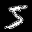

In [10]:
import requests
from PIL import Image

#load one sample from train dataset
image = train_dataset[0][0]
image = transforms.ToPILImage()(image)
image

In [11]:
x0 = train_dataset[0][0]  # Get the first image from the training dataset
x0 = x0.unsqueeze(0)  # Add batch dimension
x0.shape

torch.Size([1, 1, 32, 32])

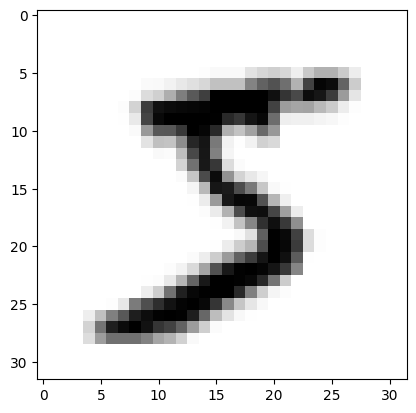

In [12]:
#plot x0
plt.imshow(x0[0].squeeze(0), cmap="binary")

In [13]:
def get_noisy_image(x0, t, transform=reverse_transform_pil):
    """
    Get the noisy image at a given timestamp t.
    """
    if t == 0:
        # Directly use the original image (no noise at t=0)
        x_t = x0.squeeze(0)
    else:
        x_t = sample_q(x0, t).squeeze(0)

    # Expand MNIST (C=1) to 3 channels if model expects RGB
    if x_t.ndim == 3 and x_t.shape[0] == 1:
        x_t = x_t.repeat(3, 1, 1)

    # Make sure values are in [0,1] before converting to image
    # x_t = torch.clamp(x_t, 0, 1)

    return transform(x_t)




def show_noisy_images(noisy_images):
  num_of_image_sets = len(noisy_images)
  num_of_images_in_set = len(noisy_images[0])
  image_size = noisy_images[0][0].size[0]

  full_image = Image.new('RGB', (image_size * num_of_images_in_set + (num_of_images_in_set - 1), image_size * num_of_image_sets + (num_of_image_sets - 1)))
  for set_index, image_set in enumerate(noisy_images):
    for image_index, image in enumerate(image_set):
      full_image.paste(image, (image_index * image_size + image_index, set_index * image_size + set_index))

  plt.imshow(full_image)
  plt.axis('off')
  return full_image

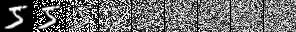

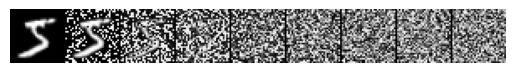

In [23]:
show_noisy_images([[get_noisy_image(x0, torch.tensor([t])) for t in [0,1, 50, 100, 150, 200,300,500,1000]]])

## BACKWARD PROCESS - > NOISE TO IMAGE

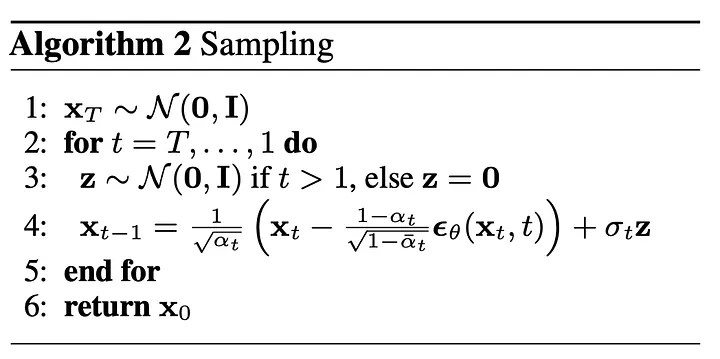

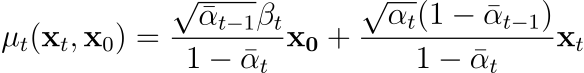

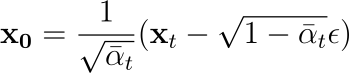



In [ ]:
@torch.no_grad()
def sample_p(model, x_t, t, labels=None, clipping=True):
  """
  Sample from p_θ(xₜ₋₁|xₜ) to get xₜ₋₁ according to Algorithm 2
  """
  betas_t_sampled = sample_by_t(betas_t, t, x_t.shape)
  sqrt_1_minus_alphas_bar_t_sampled = sample_by_t(sqrt_1_minus_alphas_bar_t, t, x_t.shape)
  one_over_sqrt_alphas_t_sampled = sample_by_t(one_over_sqrt_alphas_t, t, x_t.shape)

  if clipping:
    sqrt_alphas_bar_t_sampled = sample_by_t(sqrt_alphas_bar_t, t, x_t.shape)
    sqrt_alphas_bar_t_minus_1_sampled = sample_by_t(sqrt_alphas_bar_t_minus_1, t, x_t.shape)
    alphas_bar_t_sampled = sample_by_t(alphas_bar_t, t, x_t.shape)
    sqrt_alphas_t_sampled = sample_by_t(sqrt_alphas_t, t, x_t.shape)
    alphas_bar_t_minus_1_sampled = sample_by_t(alphas_bar_t_minus_1, t, x_t.shape)

    x0_reconstruct = 1 / sqrt_alphas_bar_t_sampled * (x_t - sqrt_1_minus_alphas_bar_t_sampled * model(x_t, t, labels))
    x0_reconstruct = torch.clip(x0_reconstruct, -1., 1.)
    predicted_mean = (sqrt_alphas_bar_t_minus_1_sampled * betas_t_sampled) / (1 - alphas_bar_t_sampled) * x0_reconstruct + (sqrt_alphas_t_sampled * (1 - alphas_bar_t_minus_1_sampled)) /  (1 - alphas_bar_t_sampled) * x_t

  else:
    predicted_mean = one_over_sqrt_alphas_t_sampled * (x_t - betas_t_sampled / sqrt_1_minus_alphas_bar_t_sampled * model(x_t, t, labels))

  if t[0].item() == 1:
    return predicted_mean
  else:
    posterior_variance_sampled = sample_by_t(posterior_variance, t, x_t.shape)
    noise = torch.randn_like(x_t)
    return predicted_mean + torch.sqrt(posterior_variance_sampled) * noise


@torch.no_grad()
def sampling(model, shape, labels=None, image_noise_steps_to_keep=1):
  """
  Implementing Algorithm 2 - sampling.
  Args:
    model (torch.Module): the model that predicts the noise
    shape (tuple): shape of the data (batch, channels, image_size, image_size)
    labels (torch.Tensor, optional): class labels for conditional generation
  Returns:
    (list): list containing the images in the different steps of the reverse process
  """

  batch = shape[0]
  images = torch.randn(shape, device=device)  # pure noise
  images_list = []

  for timestep in tqdm(range(num_timesteps, 0, -1), desc='sampling timestep'):
    images = sample_p(model, images, torch.full((batch,), timestep, device=device, dtype=torch.long), labels)
    if timestep <= image_noise_steps_to_keep:
      images_list.append(images.cpu())
  return images_list


## training code

In [18]:
#print all shapes of train and test datasets
for images, _ in train_loader:
    print("Train batch shape:", images.shape)
    break

for images, _ in test_loader:
    print("Test batch shape:", images.shape)
    break

Train batch shape: torch.Size([64, 1, 32, 32])
Test batch shape: torch.Size([64, 1, 32, 32])


In [ ]:
GabiDiffUnet()

import torch.nn.functional as F
def compute_loss(model, x0, t, labels=None, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    
    x_t = sample_q(x0, t, noise)
    predicted_noise = model(x_t, t, labels)
    loss = F.l1_loss(noise, predicted_noise)
    return loss


In [25]:
#training code 
import datetime
import time
from torch.utils.data import DataLoader
import torch.optim as optim

#hyperparameters:
parameters = {
    "time_embed_dim": 128,
    "resnet_depth": 4,
    "learning_rate": 1e-4,
    "batch_size": 64,
    "num_epochs": 1000

}

model = GabiDiffUnet(
    time_emb_dim=parameters["time_embed_dim"],
    num_classes=10,
    resnet_depth=parameters["resnet_depth"],
    image_size=32
    ).to(device)

optimizer = optim.Adam(model.parameters(), lr=parameters["learning_rate"])


from pathlib import Path
results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)

model_saved_file_path = Path('/Volumes/T7 Shield/CODING/DDPM-diffusion/saved_model.pth')
if model_saved_file_path.exists():
  saved_model = torch.load(str(model_saved_file_path))
  
else:
  model_saved_file_path.parent.mkdir(parents=True, exist_ok=True)
  saved_model = {}
  start_epoch = 0

if saved_model:
    print('loading model')
    model.load_state_dict(saved_model['model'])
    optimizer.load_state_dict(saved_model['optimizer'])
    start_epoch = saved_model['epoch']


import numpy as np
from torchvision.utils import save_image

epochs = parameters["num_epochs"]
loss_steps = 50
sample_every = 1000
loss_for_mean = np.zeros(loss_steps)

start_time = time.time()
checkpoint_every = 10


def save_checkpoint(state, filepath):
    torch.save(state, filepath)



In [ ]:

for epoch in range(start_epoch, epochs):
    for batch_index, (data, labels) in enumerate(train_loader):
        log_interval = 1

        # print(batch_index,data.shape,labels.shape)
        images = data.to(device)
        labels = labels.to(device).long()  

        # sampling t
        t = sample_t(images.shape[0]).to(device).long()

        # Pass labels to compute_loss for conditional training
        loss = compute_loss(model, images, t, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print ETA and loss
        if batch_index % log_interval == 0:
            current_time = time.time()
            elapsed_time = current_time - start_time
            remaining_time = (elapsed_time / (batch_index + 1)) * (len(train_loader) - batch_index - 1)
            print(f"Epoch [{epoch}/{epochs}], Batch [{batch_index}/{len(train_loader)}], Loss: {loss.item():.4f}, ETA: {remaining_time:.4f}")

        model.eval()
        with torch.no_grad():
            if batch_index % sample_every == 0:
                # Sample images conditionally using labels
                sample_labels = torch.arange(10, dtype=torch.long, device=device)  # Sample one of each class
                sampled_images = sampling(model, (10, 3, 32, 32), labels=sample_labels, image_noise_steps_to_keep=1)
                # Save the sampled images
                for i, img in enumerate(sampled_images):
                    save_image(img, results_folder / f"sampled_epoch{epoch}_batch{batch_index}_class{sample_labels[i]}.png", normalize=True)
        model.train()

        # checkpointing
        if batch_index % checkpoint_every == 0:
            save_checkpoint({
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': epoch,
                'batch_index': batch_index
            }, model_saved_file_path)


###TODO###
# --- Optional: classifier-free guidance support (training-time label dropout) ---
# - with prob p, replace labels with a special "null" token (or None) so model learns unconditional behavior
# - alter compute_loss to accept None and to use conditional embedding only if labels is not None

# --- Utility helpers ---
# - function sample_t(batch_size): return random timesteps in [1, num_timesteps]
# - save_checkpoint(dict, path)
# - load_checkpoint(path) -> model.load_state_dict, optimizer.load_state_dict, start_epoch
# - logging helper to compute moving average of loss and print ETA
# - sampling wrapper to decode generated images using labels (or unconditional if None)

# --- Training loop outline ---
# for epoch in range(start_epoch, epochs):
#     model.train()
#     for batch_idx, (images, labels) in enumerate(train_loader):
#         # move to device
#         images = images.to(device)           # shape (B, C, H, W)
#         labels = labels.to(device).long()   # shape (B,)
#
#         # sample timesteps for the batch
#         t = sample_t(images.shape[0]).to(device).long()
#
#         # (optional) apply classifier-free dropout to some labels:
#         #   mask = torch.rand(B) < cfg_uncond_prob
#         #   labels_for_model = labels.clone()
#         #   labels_for_model[mask] = null_label_value_or_use_None
#
#         # compute loss (pass labels_for_model or labels)
#         #   loss = compute_loss(model, images, t, labels_for_model)
#
#         # optimizer step (support amp if used)
#         #   optimizer.zero_grad()
#         #   if using_amp: scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
#         #   else: loss.backward(); optimizer.step()
#         #   if gradient_clip: clip gradients
#
#         # logging: accumulate loss into buffer, every loss_steps print mean and ETA
#
#         # sampling / visualization: every sample_every steps
#         #   model.eval()
#         #   with torch.no_grad():
#         #       # optionally sample conditioned on a set of labels
#         #       sample_labels = torch.tensor([...], dtype=torch.long, device=device)
#         #       samples = sampling(model, (batch_to_sample, 3, image_size, image_size), labels=sample_labels)
#         #       # reverse transforms and save grid with torchvision.utils.save_image
#         #   model.train()
#
#         # checkpointing: save model state dict, optimizer, epoch, step periodically
#
#     # end epoch: step lr scheduler, run validation sampling if desired, save best checkpoint

# --- Validation / Monitoring ---
# - optional: compute validation loss on held-out set (no optimizer steps)
# - sample fixed noise + labels each epoch to visualize progress (save with epoch and label in filename)

# --- Notes / Shape expectations ---
# - model(x_t, t, labels) should accept:
#     - x_t: float tensor (B, C, H, W), values roughly in [-1,1] if using Normalize
#     - t: tensor (B,) long or float depending on time embedding implementation
#     - labels: tensor (B,) long (or None for unconditional)
# - ensure time embedding in model consumes same dtype/device as t

# --- Minimal checkpoints to implement in code ---
# - change compute_loss signature to include labels
# - change sampling(...) and sample_p(...) to accept labels when conditioning sampling
# - ensure training loop passes labels everywhere and treats label-dropout if using classifier-free guidance

# End of comment-structure - implement each commented block as code in

0 torch.Size([64, 1, 32, 32]) torch.Size([64])
